#Loading Galaxy Data into Pytorch


In [ ]:
import torch
from torch import nn

In [ ]:
torch.__version__

'2.5.1+cu124'

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
!nvidia-smi

Wed Feb 19 06:51:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   36C    P8             15W /   72W |       3MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from zipfile import ZipFile
file_name = "/content/filtered_images.zip"

with ZipFile(file_name, "r") as zip:
  zip.extractall()
  print("Zip file extracted")

Zip file extracted


In [ ]:
import os
import shutil
import random

from pathlib import Path

# Get path for filtered_images

image_path = Path("filtered_images/")

# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

# Paths
base_dir = "/content/filtered_images"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

# Create train and test directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get a list of all image files
all_images = [f for f in os.listdir(base_dir) if os.path.isfile(os.path.join(base_dir, f))]

# Shuffle images and split into train/test (80% train, 20% test)
random.shuffle(all_images)
split_idx = int(0.8 * len(all_images))  # 80-20 split

train_images = all_images[:split_idx]
test_images = all_images[split_idx:]

# Move files to train directory
for img in train_images:
    shutil.move(os.path.join(base_dir, img), os.path.join(train_dir, img))

# Move files to test directory
for img in test_images:
    shutil.move(os.path.join(base_dir, img), os.path.join(test_dir, img))

print(f"Data split completed! Train: {len(train_images)} images, Test: {len(test_images)} images")

# Create 'default_class' folders
os.makedirs(os.path.join(train_dir, "default_class"), exist_ok=True)
os.makedirs(os.path.join(test_dir, "default_class"), exist_ok=True)

# Move all images into the 'default_class' folder
for img in os.listdir(train_dir):
    if os.path.isfile(os.path.join(train_dir, img)):
        shutil.move(os.path.join(train_dir, img), os.path.join(train_dir, "default_class", img))

for img in os.listdir(test_dir):
    if os.path.isfile(os.path.join(test_dir, img)):
        shutil.move(os.path.join(test_dir, img), os.path.join(test_dir, "default_class", img))

Data split completed! Train: 2381 images, Test: 596 images


#Visualizing Data

image path: filtered_images/train/default_class/114440.jpg
image size: (424, 424)


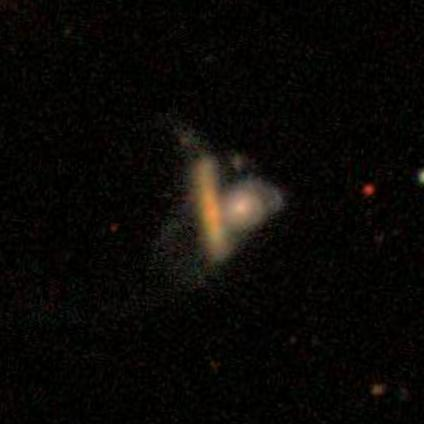

In [ ]:
import random
from PIL import Image

# Seed
random.seed(42)

# Obtain path of images
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Use Python's random.choice() to generate random images
random_image_path = random.choice(image_path_list)

# visualize image
img = Image.open(random_image_path)

# Print image specs
print(f"image path: {random_image_path}")
print(f"image size: {img.size}")

img

In [ ]:


print(img.mode)

RGB


# Data Transformation

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


In [ ]:
data_transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize slightly larger
    transforms.RandomRotation(degrees=30),
    transforms.CenterCrop(128),  # ✅ Keeps rotated galaxy centered
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.3, contrast=0.8, saturation=0.6, hue=0.1),
    transforms.ToTensor()
])



In [ ]:
data_transform(img)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

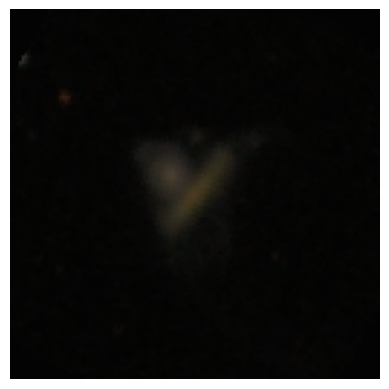

In [ ]:
import matplotlib.pyplot as plt

# Apply transformations to the image
transformed_img = data_transform(img)

# Convert (C, H, W) tensor to (H, W, C) for visualization
plt.imshow(transformed_img.permute(1, 2, 0))
plt.axis("off")
plt.show()


In [ ]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 2381
    Root location: /content/filtered_images/train
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=True)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               CenterCrop(size=(128, 128))
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=(0.7, 1.3), contrast=(0.19999999999999996, 1.8), saturation=(0.4, 1.6), hue=(-0.1, 0.1))
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 596
    Root location: /content/filtered_images/test
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=True)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               CenterCrop(size=(128, 128))
              

In [ ]:
# Check CPUs available for num_workers
os.cpu_count()

12

In [ ]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=64, # how many samples per batch?
                              num_workers=2, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=64,
                             num_workers=2,
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7aa2b0722850>,
 <torch.utils.data.dataloader.DataLoader at 0x7aa2b0720690>)

#Building the GAN

In [ ]:
# Generator
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        self.main = nn.Sequential(
            nn.Linear(noise_dim, 8 * 8 * 512),
            nn.ReLU(True),
            nn.Unflatten(1, (512, 8, 8)),
            nn.ConvTranspose2d(512, 256, 5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 5, stride=2, padding=2, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)




In [ ]:
# Discriminator

import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),  # ⬅ Add Dropout

            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(128),
            nn.Dropout(0.3),  # ⬅ Add Dropout

            nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(256),
            nn.Dropout(0.3),  # ⬅ Add Dropout

            nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(512),
            nn.Dropout(0.3),  # ⬅ Add Dropout

            nn.Conv2d(512, 1024, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(1024 * 4 * 4, 1),
        )

    def forward(self, x):
        return self.main(x)




In [ ]:
# Noise dimension
NOISE_DIM = 128

# Generator and discriminator
generator = Generator(NOISE_DIM)
discriminator = Discriminator()

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = generator.to(device)
discriminator = discriminator.to(device)

In [ ]:
# Loss function
criterion = nn.BCEWithLogitsLoss()

# Optimizers
generator_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.00001, betas=(0.5, 0.999))

# Training hyperparameters
NUM_EPOCHS = 1000
BATCH_SIZE = 128

In [ ]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

generator.apply(weights_init)
discriminator.apply(weights_init)


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.3, inplace=False)
    (7): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.3, inplace=False)
    (11): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout(p=0.3, inplace=False)
    (15): Conv2d

In [ ]:
# Training loop
from torchvision.utils import save_image
import torch
import torch.nn as nn
import torch.optim as optim

# Training loop
for epoch in range(NUM_EPOCHS):
    for i, data in enumerate(train_dataloader):
        # Load real images
        real_images, _ = data
        real_images = real_images.to(device)

        # Train discriminator with real images
        discriminator_optimizer.zero_grad()
        real_labels = torch.ones(real_images.size(0), 1, device=device)  # Label = 1 for real
        real_outputs = discriminator(real_images)
        real_loss = criterion(real_outputs, real_labels)
        real_loss.backward()

        # Train discriminator with fake images
        noise = torch.randn(real_images.size(0), NOISE_DIM, device=device)  # Generate noise
        fake_images = generator(noise)  # Generate fake images
        fake_labels = torch.zeros(real_images.size(0), 1, device=device)  # Label = 0 for fake
        fake_outputs = discriminator(fake_images.detach())  # Detach to avoid generator updates
        fake_loss = criterion(fake_outputs, fake_labels)
        fake_loss.backward()
        discriminator_optimizer.step()  # Update discriminator weights

        # Train generator
        generator_optimizer.zero_grad()
        fake_labels = torch.ones(real_images.size(0), 1, device=device)  # Flip labels for generator
        fake_outputs = discriminator(fake_images)  # Recalculate discriminator outputs
        gen_loss = criterion(fake_outputs, fake_labels)
        gen_loss.backward()
        generator_optimizer.step()  # Update generator weights

        # Print losses and progress
        if i % 10 == 0:
            print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Step [{i+1}/{len(train_dataloader)}], '
                  f'Discriminator Loss: {real_loss.item() + fake_loss.item():.4f}, '
                  f'Generator Loss: {gen_loss.item():.4f}')

    # Save generated images to monitor progress
    if (epoch + 1) % 10 == 0:  # Save images every 10 epochs
        with torch.no_grad():
            test_noise = torch.randn(16, NOISE_DIM, device=device)
            generated_images = generator(test_noise)
            save_image(generated_images, f'output_epoch_{epoch+1}.png', normalize=True)

    # Save model checkpoints
    if (epoch + 1) % 10 == 0:  # Save model weights every 10 epochs
        torch.save(generator.state_dict(), f'generator_epoch_{epoch+1}.pth')
        torch.save(discriminator.state_dict(), f'discriminator_epoch_{epoch+1}.pth')

    if (epoch + 1) % 10 == 0:
      checkpoint = {
          'epoch': epoch+1,
          'generator_state_dict': generator.state_dict(),
          'discriminator_state_dict': discriminator.state_dict(),
          'generator_optimizer_state_dict': generator_optimizer.state_dict(),
          'discriminator_optimizer_state_dict': discriminator_optimizer.state_dict()
      }
      torch.save(checkpoint, f'gan_checkpoint_epoch_{epoch+1}.pth')

    test_noise = torch.randn(16, NOISE_DIM, device=device)  # Use consistent noise for visual consistency
    generate_and_save_images(generator, epoch, test_noise)


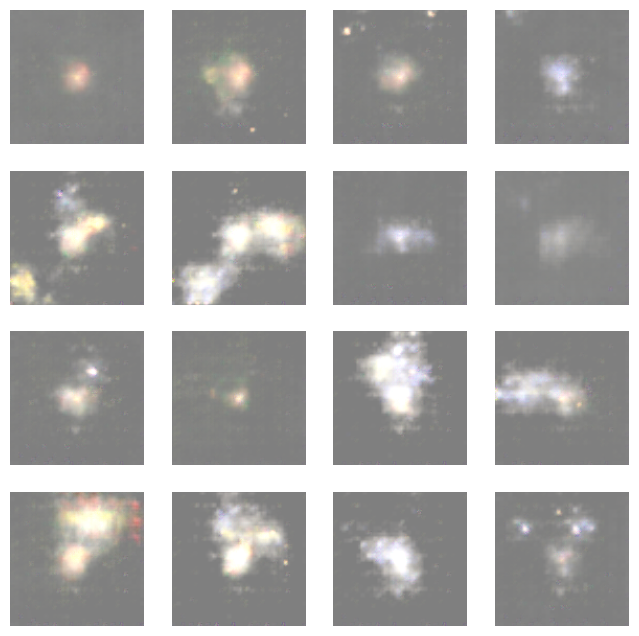

In [ ]:
import matplotlib.pyplot as plt

# Generate and save images
def generate_and_save_images(model, epoch, noise):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Generate fake images
        fake_images = model(noise).cpu()

        fake_images = fake_images * 1.2  # Expand [-1,1] → [-1.1, 1.1]
        fake_images = torch.clamp(fake_images, -1, 1)  # Keep within valid range
        fake_images = (fake_images + 1) / 2  # Convert to [0,1]


        # Prepare figure
        fig = plt.figure(figsize=(8, 8))  # Adjust size for 128x128 images
        grid_size = int(noise.size(0) ** 0.5)

        for i in range(noise.size(0)):
            plt.subplot(grid_size, grid_size, i + 1)
            # Convert from (C, H, W) to (H, W, C) for visualization
            img = fake_images[i].permute(1, 2, 0).numpy()
            plt.imshow(img)
            plt.axis('off')

        # Save and show the image grid
        plt.savefig(f'image_at_epoch_{epoch+1:04d}.png')
        plt.show()

# Generate test noise
test_noise = torch.randn(16, NOISE_DIM, device=device)  # 16 samples (4x4 grid)
generate_and_save_images(generator, NUM_EPOCHS, test_noise)


In [ ]:
print(f"Total dataset size: {len(train_dataloader.dataset)}")
print(f"Number of batches: {len(train_dataloader)}")


Total dataset size: 2381
Number of batches: 38


In [ ]:
checkpoint = torch.load("generator_epoch_250.pth")
print(checkpoint.keys())

odict_keys(['main.0.weight', 'main.0.bias', 'main.3.weight', 'main.3.bias', 'main.4.weight', 'main.4.bias', 'main.4.running_mean', 'main.4.running_var', 'main.4.num_batches_tracked', 'main.6.weight', 'main.6.bias', 'main.7.weight', 'main.7.bias', 'main.7.running_mean', 'main.7.running_var', 'main.7.num_batches_tracked', 'main.9.weight', 'main.9.bias', 'main.10.weight', 'main.10.bias', 'main.10.running_mean', 'main.10.running_var', 'main.10.num_batches_tracked', 'main.12.weight', 'main.12.bias'])


<ipython-input-185-e3935a45ae84>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("generator_epoch_250.pth")


In [ ]:
from google.colab import files
files.download("output_epoch_950.png")  # Replace with the exact filename


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>